# ML Libraries Performance and GPU Utilization Check

This script checks the installation and performance of various machine learning libraries. It assesses both CPU and GPU performance (if available) for each library.

## Import Required Libraries

We begin by importing necessary libraries and modules.

In [19]:
import sys
import time
import torch
import tensorflow as tf
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
import warnings

# Suppressing warnings, especially for TensorFlow
warnings.filterwarnings('ignore')

## Performance Measurement Functions

For each library, we define a function to measure its performance on both CPU and GPU.


## GPU Availability Check

We also check if the GPU is available for each library.

In [20]:
# Nvidia Check
!nvidia-smi

# Performance Measurement for PyTorch
def measure_performance_torch(device, size=1000):
    start_time = time.time()
    a = torch.rand(size, size, device=device)
    b = torch.rand(size, size, device=device)
    torch.matmul(a, b)
    end_time = time.time()
    return end_time - start_time

# Performance Measurement for TensorFlow
def measure_performance_tensorflow(device_name, size=1000):
    with tf.device(device_name):
        start_time = time.time()
        a = tf.random.normal([size, size])
        b = tf.random.normal([size, size])
        tf.matmul(a, b)
        end_time = time.time()
        return end_time - start_time

# Performance Measurement for Scikit-learn
def measure_performance_sklearn(size=1000):
    X, y = make_classification(n_samples=size, n_features=20, n_classes=2, random_state=42)
    clf = RandomForestClassifier()
    start_time = time.time()
    clf.fit(X, y)
    end_time = time.time()
    return end_time - start_time

# Check GPU support for libraries
def check_gpu_support(library):
    if library == 'torch' and torch.cuda.is_available():
        return True, torch.cuda.get_device_name(0)
    elif library == 'tensorflow' and tf.config.list_physical_devices('GPU'):
        return True, None
    else:
        return False, None

# Main function to measure and display performance
def main():
    libraries_to_test = ["torch", "tensorflow", "scikit-learn"]  # Libraries to test
    num_tests = 10  # Number of tests per library
    results = []  # Storing results

    for lib in libraries_to_test:
        gpu_available, gpu_name = check_gpu_support(lib)
        for i in range(num_tests):
            if lib == 'torch':
                cpu_time = measure_performance_torch("cpu")
                gpu_time = measure_performance_torch("cuda") if gpu_available else None
            elif lib == 'tensorflow':
                cpu_time = measure_performance_tensorflow("/cpu:0")
                gpu_time = measure_performance_tensorflow("/gpu:0") if gpu_available else None
            elif lib == 'scikit-learn':
                cpu_time = measure_performance_sklearn()
                gpu_time = None
            
            # Store the results
            results.append({
                "Library": lib,
                "Test": i + 1,
                "CPU Time (ms)": cpu_time * 1000,  # Convert to milliseconds
                "GPU Time (ms)": gpu_time * 1000 if gpu_time else "N/A",  # Convert to milliseconds
                "GPU Available": gpu_available,
                "GPU Name": gpu_name
            })

    # Print results in a tabular format
    print_table(results)

# Function to print results in a table format
def print_table(data):
    # Determine the maximum width needed for each column
    column_widths = {
        "Library": max(len(row["Library"]) for row in data),
        "Test": len("Test"),
        "CPU Time (ms)": max(len(f"{row['CPU Time (ms)']:.6f}") for row in data),
        "GPU Time (ms)": max(len(str(row["GPU Time (ms)"])) for row in data),
        "Speedup": len("Speedup")
    }

    # Headers
    headers = ["Library", "Test", "CPU Time (ms)", "GPU Time (ms)", "Speedup"]
    header_row = "| " + " | ".join(headers[i].ljust(column_widths[headers[i]]) for i in range(len(headers))) + " |"

    # Separator
    separator = "+-" + "-+-".join(["-" * column_widths[header] for header in headers]) + "-+"

    # Print the table
    print(separator)
    print(header_row)
    print(separator)
    for row in data:
        cpu_time = row["CPU Time (ms)"]
        gpu_time = row["GPU Time (ms)"]
        # Calculate speedup
        if gpu_time != "N/A" and float(gpu_time) > 0:
            speedup = cpu_time / float(gpu_time)
            speedup_text = f"{speedup:.2f}x" if speedup >= 1 else f"{100 * (1 - gpu_time / cpu_time):.2f}% faster"
        else:
            speedup_text = "N/A"

        formatted_row = "| " + " | ".join([
            row["Library"].ljust(column_widths["Library"]),
            str(row["Test"]).ljust(column_widths["Test"]),
            f"{row['CPU Time (ms)']:.6f}".ljust(column_widths["CPU Time (ms)"]),
            str(row["GPU Time (ms)"]).ljust(column_widths["GPU Time (ms)"]),
            speedup_text.ljust(column_widths["Speedup"])
        ]) + " |"
        print(formatted_row)
    print(separator)

if __name__ == "__main__":
    main()


Thu Dec  7 09:23:55 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.06              Driver Version: 546.17       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4080        On  | 00000000:01:00.0  On |                  N/A |
| 30%   40C    P0              41W / 288W |  15781MiB / 16376MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Loading all essential libraries including Cudf to speed up Pandas

# Download the data

The data we'll be working with is the [Parking Violations Issued - Fiscal Year 2022](https://data.cityofnewyork.us/City-Government/Parking-Violations-Issued-Fiscal-Year-2022/7mxj-7a6y) dataset from NYC Open Data.

We're downloading a copy of this dataset from an s3 bucket hosted by NVIDIA to provide faster download speeds. We'll start by downloading the data. This should take about 30 seconds.

## Data License and Terms
As this dataset originates from the NYC Open Data Portal, it's governed by their license and terms of use.

### Are there restrictions on how I can use Open Data?

> Open Data belongs to all New Yorkers. There are no restrictions on the use of Open Data. Refer to Terms of Use for more information.

### [Terms of Use](https://opendata.cityofnewyork.us/overview/#termsofuse)

> By accessing datasets and feeds available through NYC Open Data, the user agrees to all of the Terms of Use of NYC.gov as well as the Privacy Policy for NYC.gov. The user also agrees to any additional terms of use defined by the agencies, bureaus, and offices providing data. Public data sets made available on NYC Open Data are provided for informational purposes. The City does not warranty the completeness, accuracy, content, or fitness for any particular purpose or use of any public data set made available on NYC Open Data, nor are any such warranties to be implied or inferred with respect to the public data sets furnished therein.

> The City is not liable for any deficiencies in the completeness, accuracy, content, or fitness for any particular purpose or use of any public data set, or application utilizing such data set, provided by any third party.

> Submitting City Agencies are the authoritative source of data available on NYC Open Data. These entities are responsible for data quality and retain version control of data sets and feeds accessed on the Site. Data may be updated, corrected, or refreshed at any time.

In [22]:
!wget https://data.rapids.ai/datasets/nyc_parking/nyc_parking_violations_2022.parquet


--2023-12-07 09:38:58--  https://data.rapids.ai/datasets/nyc_parking/nyc_parking_violations_2022.parquet
Resolving data.rapids.ai (data.rapids.ai)... 18.172.202.44, 18.172.202.119, 18.172.202.4, ...
Connecting to data.rapids.ai (data.rapids.ai)|18.172.202.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 477161608 (455M) [binary/octet-stream]
Saving to: ‘nyc_parking_violations_2022.parquet.1’

nyc_parking_violati 100%[===================>] 455.06M  16.1MB/s    in 30s     

2023-12-07 09:39:29 (15.3 MB/s) - ‘nyc_parking_violations_2022.parquet.1’ saved [477161608/477161608]



## Functions that test Pandas vs cuDF and post a plot in plotly express about them and data


------------------------+---------------+------------------+-------------+----------------+---------------------
Operation               |Pandas Time (s)|Pandas Memory (MB)|cuDF Time (s)|cuDF Memory (MB)|Performance Boost (%)
------------------------+---------------+------------------+-------------+----------------+---------------------
Value Counts by State   |6.8549         |2091.2344         |0.4975       |2062.8945       |92.74%               
Aggregation by Body Type|6.5390         |2141.1836         |0.5010       |2125.5898       |92.34%               
Count by Weekday        |6.6512         |2080.6406         |0.4908       |2059.2734       |92.62%               
------------------------+---------------+------------------+-------------+----------------+---------------------


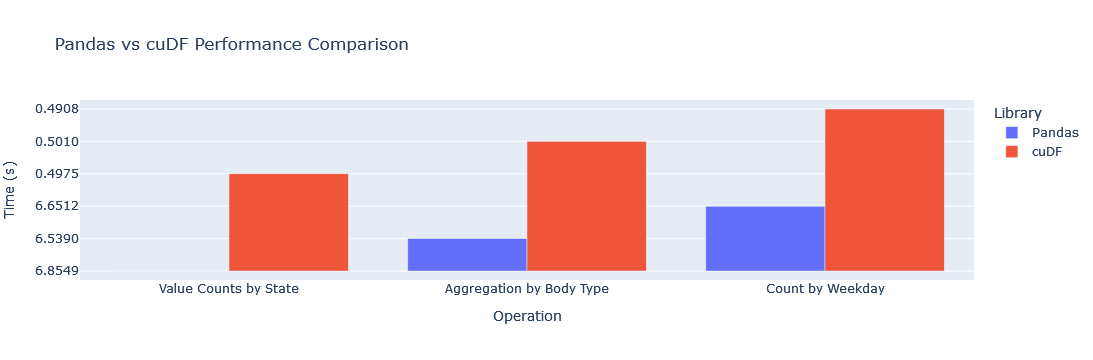

In [10]:
import pandas as pd
import cudf
import time
import plotly.express as px
from memory_profiler import memory_usage

# Pandas Operations
def pandas_operations():
    df = pd.read_parquet("nyc_parking_violations_2022.parquet", columns=["Registration State", "Violation Description", "Vehicle Body Type", "Issue Date", "Summons Number"])

    # Operation 1
    op1 = (df[["Registration State", "Violation Description"]]
           .value_counts()
           .groupby("Registration State")
           .head(1)
           .sort_index()
           .reset_index())

    # Operation 2
    op2 = (df
           .groupby(["Vehicle Body Type"])
           .agg({"Summons Number": "count"})
           .rename(columns={"Summons Number": "Count"})
           .sort_values(["Count"], ascending=False))

    # Operation 3
    weekday_names = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"}
    df["Issue Date"] = df["Issue Date"].astype("datetime64[ms]")
    df["issue_weekday"] = df["Issue Date"].dt.weekday.map(weekday_names)
    op3 = df.groupby(["issue_weekday"])["Summons Number"].count().sort_values()

    return op1, op2, op3

# cuDF Operations
def cudf_operations():
    df = cudf.read_parquet("nyc_parking_violations_2022.parquet", columns=["Registration State", "Violation Description", "Vehicle Body Type", "Issue Date", "Summons Number"])

    # Operation 1
    op1 = (df[["Registration State", "Violation Description"]]
           .value_counts()
           .groupby("Registration State")
           .head(1)
           .sort_index()
           .reset_index())

    # Operation 2
    op2 = (df
           .groupby(["Vehicle Body Type"])
           .agg({"Summons Number": "count"})
           .rename(columns={"Summons Number": "Count"})
           .sort_values(["Count"], ascending=False))

    # Operation 3
    weekday_names = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"}
    df["Issue Date"] = df["Issue Date"].astype("datetime64[ms]")
    df["issue_weekday"] = df["Issue Date"].dt.weekday.map(weekday_names)
    op3 = df.groupby(["issue_weekday"])["Summons Number"].count().sort_values()

    return op1, op2, op3
# Define the list of operation names
operations = ['Value Counts by State', 'Aggregation by Body Type', 'Count by Weekday']


# Modified Benchmarking Function
def benchmark_operation(pd_func, cudf_func, operation_index):
    # Measure Pandas performance
    pandas_start_time = time.time()
    pd_result = pd_func()[operation_index]  # Get specific operation result
    pandas_time = time.time() - pandas_start_time
    pandas_memory = max(memory_usage((lambda: pd_result, )))  # Memory usage

    # Measure cuDF performance
    cudf_start_time = time.time()
    cudf_result = cudf_func()[operation_index]  # Get specific operation result
    cudf_time = time.time() - cudf_start_time
    cudf_memory = max(memory_usage((lambda: cudf_result, )))  # Memory usage

    # Performance boost calculation
    boost = 100 * (pandas_time - cudf_time) / pandas_time if pandas_time > 0 else 0

    return pandas_time, pandas_memory, cudf_time, cudf_memory, boost


def display_results(results):
    # Define headers
    headers = ["Operation", "Pandas Time (s)", "Pandas Memory (MB)", "cuDF Time (s)", "cuDF Memory (MB)", "Performance Boost (%)"]

    # Determine the column widths based on the maximum length of data in each column
    max_widths = [len(header) for header in headers]
    for result in results:
        for i, value in enumerate(result):
            max_widths[i] = max(max_widths[i], len(str(value)))

    # Create the header row
    header_row = "|".join([f"{header:<{max_widths[i]}}" for i, header in enumerate(headers)])

    # Create the separator row
    separator_row = "+".join(["-" * max_widths[i] for i in range(len(headers))])

    # Print the header row and separator row
    print(separator_row)
    print(header_row)
    print(separator_row)

    # Iterate through the results and print each row
    for result in results:
        row = "|".join([f"{str(result[i]):<{max_widths[i]}}" for i in range(len(result))])
        print(row)

    # Print the separator row at the end
    print(separator_row)

# Collecting and Displaying Results
results = []
for i, op in enumerate(operations):
    pandas_time, pandas_memory, cudf_time, cudf_memory, boost = benchmark_operation(pandas_operations, cudf_operations, i)
    results.append([op, f"{pandas_time:.4f}", f"{pandas_memory:.4f}", f"{cudf_time:.4f}", f"{cudf_memory:.4f}", f"{boost:.2f}%"])

# Display results in a wider table
display_results(results)

# Plotting results
# Prepare data for Plotly
plot_data = []
for result in results:
    operation, pandas_time, pandas_memory, cudf_time, cudf_memory, boost = result
    plot_data.append({"Operation": operation, "Library": "Pandas", "Time (s)": pandas_time})
    plot_data.append({"Operation": operation, "Library": "cuDF", "Time (s)": cudf_time})

# Convert to DataFrame for easy plotting
plot_df = pd.DataFrame(plot_data)

# Plotting results
fig = px.bar(
    plot_df, 
    x="Operation", 
    y="Time (s)", 
    color="Library",
    barmode='group',
    labels={"Operation": "Operation", "Time (s)": "Time (s)"},
    title="Pandas vs cuDF Performance Comparison"
)


fig.show()



## Follow with coding now that we know if all is fine.


In [ ]:
# CUDF - GPU Dataframe
# cudf is a GPU DataFrame library for loading, joining, aggregating, filtering, and otherwise manipulating tabular data using a DataFrame style API.    
  
%load_ext cudf.pandas

# Importing libraries
#=============================
import cudf
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium
#=============================


### Get data 